# 04 — Dynamic Hedge Ratios + Regime Filters (Kalman + Rolling OLS)

This notebook extends the core pairs-trading pipeline with **adaptive hedge ratios** and **basic regime filters**, plus a more explicit (still simplified) **transaction cost** model.

## What’s inside

1. **Static OLS beta** (baseline)
2. **Rolling OLS beta** (re-estimate every day using last *M* days)
3. **Kalman filter beta** (time-varying hedge ratio)
4. **Regime filters**
   - Volatility filter (avoid high-vol spread regimes)
   - Trend filter (avoid trading when spread trend is strong)
5. **Transaction costs / slippage** (bps + half-spread proxy)
6. **Portfolio constraints** (optional multi-pair aggregation)

> Note: This is intentionally lightweight and dependency-minimal (no `pyarrow`, no extra Kalman packages).  
> The Kalman filter here is implemented directly in NumPy.

---

## Data caching

Uses **CSV caching** to avoid parquet engine requirements (`pyarrow` / `fastparquet`).


In [1]:
from __future__ import annotations

import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
CACHE_DIR = DATA_DIR / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CACHE_DIR:", CACHE_DIR)


PROJECT_ROOT: /Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/notebooks
CACHE_DIR: /Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/notebooks/data/cache


In [2]:
# Load prices (Adj Close) 
TICKERS = ["NVDA", "JPM", "AMZN", "META"]  # edit freely
START = "2016-01-01"
END = None

PRICE_CACHE_CSV = CACHE_DIR / f"adj_close_{START}_to_{END or 'today'}_{'-'.join(TICKERS)}.csv"

def download_adj_close_yf(tickers: list[str], start: str, end: str | None) -> pd.DataFrame:
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        out = df["Adj Close"].copy()
    else:
        out = df.rename(columns={"Adj Close": tickers[0]})[tickers[0]].to_frame()
    out.index = pd.to_datetime(out.index)
    out = out.sort_index().dropna(how="all")
    return out

def load_prices(tickers: list[str], start: str, end: str | None, cache_path: Path) -> pd.DataFrame:
    if cache_path.exists():
        px = pd.read_csv(cache_path, index_col=0, parse_dates=True)
        missing = [t for t in tickers if t not in px.columns]
        if missing:
            raise ValueError(f"Cache exists but missing tickers: {missing}. Delete cache or update tickers.")
        return px[tickers].dropna().copy()
    px = download_adj_close_yf(tickers, start, end).dropna()
    px.to_csv(cache_path)
    print(f"Saved cache -> {cache_path}")
    return px

prices = load_prices(TICKERS, START, END, PRICE_CACHE_CSV)
prices.head()


,NVDA,JPM,AMZN,META
Date,,,,
2016-01-04,0.789588,48.868286,31.849501,101.510918
2016-01-05,0.802272,48.952766,31.689501,102.017380
2016-01-06,0.769098,48.246109,31.632500,102.255722
2016-01-07,0.738607,46.295055,30.396999,97.240738
2016-01-08,0.722752,45.258072,30.352501,96.654839


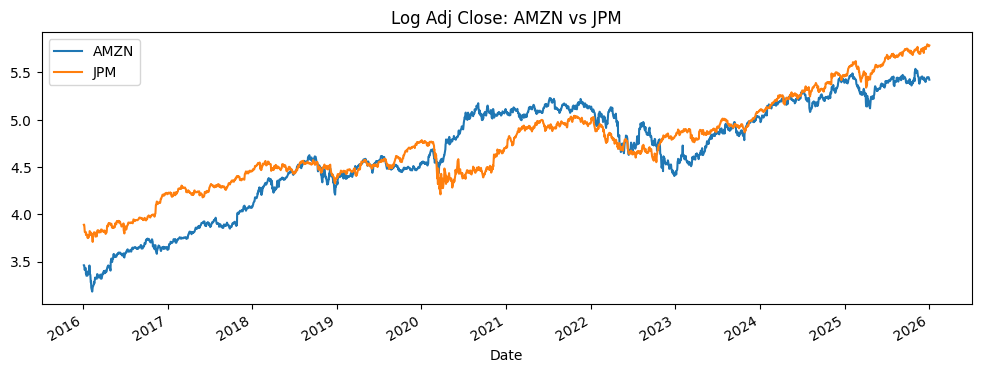

In [4]:
# Choose the pair to experiment with (you can iterate later)
PAIR = ("AMZN", "JPM")  # or ("AMZN","META")
A, B = PAIR
pA = prices[A].copy()
pB = prices[B].copy()

# Plot log prices for context
ax = np.log(pd.concat([pA, pB], axis=1)).plot(figsize=(12, 4), title=f"Log Adj Close: {A} vs {B}")
ax.set_xlabel("Date")
plt.show()


## Hedge ratio estimators

In [5]:
def ols_beta(y: pd.Series, x: pd.Series) -> float:
    df = pd.concat([y, x], axis=1).dropna()
    yv = df.iloc[:, 0].values
    xv = sm.add_constant(df.iloc[:, 1].values)
    model = sm.OLS(yv, xv).fit()
    return float(model.params[1])

def rolling_ols_beta(y: pd.Series, x: pd.Series, window: int = 252, min_periods: int | None = None) -> pd.Series:
    """Rolling beta via OLS on a trailing window."""
    if min_periods is None:
        min_periods = max(60, window // 3)

    betas = []
    idx = y.index.intersection(x.index)
    y = y.loc[idx]
    x = x.loc[idx]

    for i in range(len(idx)):
        j0 = max(0, i - window + 1)
        ys = y.iloc[j0:i+1]
        xs = x.iloc[j0:i+1]
        if len(ys) < min_periods:
            betas.append(np.nan)
            continue
        betas.append(ols_beta(ys, xs))
    return pd.Series(betas, index=idx, name="beta_rolling_ols").ffill()

def kalman_beta(
    y: pd.Series,
    x: pd.Series,
    q: float = 1e-5,      # process noise variance (state drift)
    r: float = 1e-2,      # observation noise variance
    init_beta: float | None = None,
    init_P: float = 1.0,
) -> pd.Series:
    """1D Kalman filter for time-varying beta with random-walk state.

    Model:
      beta_t = beta_{t-1} + w_t,   w_t ~ N(0, q)
      y_t   = beta_t * x_t + v_t,  v_t ~ N(0, r)

    We omit alpha for simplicity (mean shift tends to be absorbed by spread mean/z-score).
    If you want alpha, you can filter 2D state [alpha, beta].
    """
    idx = y.index.intersection(x.index)
    y = y.loc[idx].astype(float)
    x = x.loc[idx].astype(float)

    beta = np.zeros(len(idx))
    P = np.zeros(len(idx))

    if init_beta is None:
        n0 = min(100, len(idx))
        init_beta = ols_beta(y.iloc[:n0], x.iloc[:n0])

    beta_prev = float(init_beta)
    P_prev = float(init_P)

    for t in range(len(idx)):
        beta_pred = beta_prev
        P_pred = P_prev + q

        xt = x.iloc[t]
        yt = y.iloc[t]

        S = (xt * xt) * P_pred + r
        K = (P_pred * xt) / (S + 1e-12)

        beta_upd = beta_pred + K * (yt - xt * beta_pred)
        P_upd = (1.0 - K * xt) * P_pred

        beta[t] = beta_upd
        P[t] = P_upd

        beta_prev, P_prev = beta_upd, P_upd

    return pd.Series(beta, index=idx, name="beta_kalman")

beta_static = ols_beta(pA, pB)
beta_roll = rolling_ols_beta(pA, pB, window=252)
beta_kf = kalman_beta(pA, pB, q=1e-5, r=1e-2)

beta_static, beta_roll.dropna().iloc[:3], beta_kf.dropna().iloc[:3]


(0.777323997223737,
 Date
 2016-05-03    0.703389
 2016-05-04    0.721149
 2016-05-05    0.733937
 Name: beta_rolling_ols, dtype: float64,
 Date
 2016-01-04    0.651743
 2016-01-05    0.648347
 2016-01-06    0.653858
 Name: beta_kalman, dtype: float64)

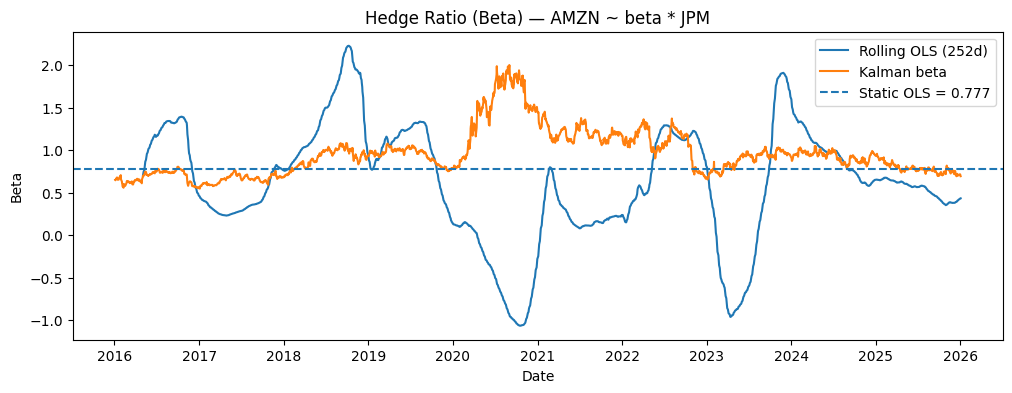

In [6]:
# Visualize hedge ratios
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(beta_roll.index, beta_roll.values, label="Rolling OLS (252d)")
ax.plot(beta_kf.index, beta_kf.values, label="Kalman beta")
ax.axhline(beta_static, linestyle="--", label=f"Static OLS = {beta_static:.3f}")
ax.set_title(f"Hedge Ratio (Beta) — {A} ~ beta * {B}")
ax.set_xlabel("Date")
ax.set_ylabel("Beta")
ax.legend()
plt.show()


## Spread + z-score (with adaptive beta)

We’ll compute spread as:

\[
s_t = p^A_t - \beta_t p^B_t
\]

Then z-score using a rolling mean/std to keep the strategy adaptive (still simple).


In [7]:
def spread(pA: pd.Series, pB: pd.Series, beta: float | pd.Series) -> pd.Series:
    if isinstance(beta, pd.Series):
        idx = pA.index.intersection(pB.index).intersection(beta.index)
        return (pA.loc[idx] - beta.loc[idx] * pB.loc[idx]).rename("spread")
    else:
        idx = pA.index.intersection(pB.index)
        return (pA.loc[idx] - float(beta) * pB.loc[idx]).rename("spread")

def rolling_zscore(s: pd.Series, lookback: int = 60, eps: float = 1e-12) -> pd.Series:
    mu = s.rolling(lookback, min_periods=max(30, lookback//2)).mean()
    sd = s.rolling(lookback, min_periods=max(30, lookback//2)).std(ddof=0)
    sd = sd.clip(lower=eps)
    return ((s - mu) / sd).rename("z")

spr_static = spread(pA, pB, beta_static)
spr_roll = spread(pA, pB, beta_roll)
spr_kf = spread(pA, pB, beta_kf)

z_static = rolling_zscore(spr_static, lookback=60)
z_roll = rolling_zscore(spr_roll, lookback=60)
z_kf = rolling_zscore(spr_kf, lookback=60)

pd.concat([spr_static, spr_roll, spr_kf], axis=1).dropna().head()


,spread,spread,spread
Date,,,
2016-05-03,-4.064125,-0.484945,0.101975
2016-05-04,-3.489649,-0.813256,0.152595
2016-05-05,-3.881646,-1.825613,-0.064931
2016-05-06,-3.355184,-2.111003,0.120085
2016-05-09,-2.830604,-2.374324,0.156219


In [8]:
# Compare spread variability (lower variance can help mean-reversion stability)
summary = pd.DataFrame({
    "spread_std": [spr_static.std(), spr_roll.std(), spr_kf.std()],
    "spread_mean": [spr_static.mean(), spr_roll.mean(), spr_kf.mean()],
}, index=["static_ols", "rolling_ols", "kalman"])
summary


,spread_std,spread_mean
static_ols,27.700891,21.758583
rolling_ols,87.307305,45.445661
kalman,0.210768,0.002691


## Regime filters

Two simple filters (both optional):

1. **Volatility filter**: avoid trading when spread realized vol is above a percentile threshold  
2. **Trend filter**: avoid trading when spread has strong directional drift

These won’t “fix” a broken strategy, but they often reduce tail risk / whipsaw.


In [9]:
def vol_filter(s: pd.Series, lookback: int = 20, max_pctile: float = 0.8) -> pd.Series:
    vol = s.diff().rolling(lookback, min_periods=max(10, lookback//2)).std(ddof=0)
    thr = vol.quantile(max_pctile)
    return (vol <= thr).rename("vol_ok")

def trend_filter(s: pd.Series, lookback: int = 60, max_abs_slope_z: float = 1.5) -> pd.Series:
    idx = np.arange(len(s), dtype=float)
    s2 = s.copy()
    s_std = s2.rolling(lookback, min_periods=max(30, lookback//2)).std(ddof=0)

    slopes = pd.Series(np.nan, index=s.index, name="slope")
    for i in range(len(s2)):
        j0 = max(0, i - lookback + 1)
        ys = s2.iloc[j0:i+1].values
        xs = idx[j0:i+1]
        if len(ys) < max(30, lookback//2):
            continue
        x_center = xs - xs.mean()
        slope = (x_center @ (ys - ys.mean())) / (x_center @ x_center + 1e-12)
        slopes.iloc[i] = slope

    slope_z = (slopes * lookback) / (s_std + 1e-12)
    return (slope_z.abs() <= max_abs_slope_z).rename("trend_ok")

vf = vol_filter(spr_kf, lookback=20, max_pctile=0.8)
tf = trend_filter(spr_kf, lookback=60, max_abs_slope_z=1.5)
filters = (vf & tf).rename("trade_ok")

filters.value_counts(dropna=False), filters.head()


(trade_ok
 True     1993
 False     522
 Name: count, dtype: int64,
 Date
 2016-01-04    False
 2016-01-05    False
 2016-01-06    False
 2016-01-07    False
 2016-01-08    False
 Name: trade_ok, dtype: bool)

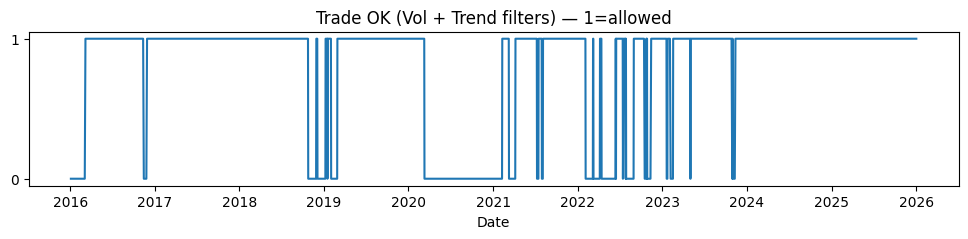

In [10]:
# Visualize regimes: where trading is allowed
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(filters.index, filters.astype(int).values)
ax.set_title("Trade OK (Vol + Trend filters) — 1=allowed")
ax.set_xlabel("Date")
ax.set_yticks([0, 1])
plt.show()


## Backtest (adaptive beta + filters + costs)

Positions:
- If `z <= -entry`: **long spread** (long A, short beta*B)
- If `z >= entry`: **short spread**
- Exit when `|z| <= exit`

Costs:
- `cost_bps` on turnover (bps per gross notional turn)
- `half_spread_bps` extra per turnover (crude slippage proxy)


In [11]:
def backtest_with_beta(
    pA: pd.Series,
    pB: pd.Series,
    beta: float | pd.Series,
    z: pd.Series,
    trade_ok: pd.Series | None = None,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    cost_bps: float = 0.0,
    half_spread_bps: float = 0.0,
) -> pd.DataFrame:
    idx = pA.index.intersection(pB.index).intersection(z.index)
    pA, pB, z = pA.loc[idx], pB.loc[idx], z.loc[idx]

    if isinstance(beta, pd.Series):
        beta = beta.loc[idx].ffill()
    else:
        beta = pd.Series(float(beta), index=idx)

    if trade_ok is None:
        trade_ok = pd.Series(True, index=idx)
    else:
        trade_ok = trade_ok.loc[idx].fillna(False)

    spr = (pA - beta * pB).rename("spread")

    pos = pd.Series(0.0, index=idx)
    state = 0.0
    for t in idx:
        if (not trade_ok.loc[t]) or np.isnan(z.loc[t]):
            state = 0.0
            pos.loc[t] = 0.0
            continue

        zt = z.loc[t]
        if state == 0.0:
            if zt <= -entry_z:
                state = +1.0
            elif zt >= entry_z:
                state = -1.0
        else:
            if abs(zt) <= exit_z:
                state = 0.0
        pos.loc[t] = state

    ds = spr.diff().fillna(0.0)
    pnl = (pos.shift(1).fillna(0.0) * ds).rename("pnl")

    turnover = pos.diff().abs().fillna(0.0).rename("turnover")
    gross = (1.0 + beta.abs())
    tc = turnover * (cost_bps / 10_000.0) * gross
    sl = turnover * (half_spread_bps / 10_000.0) * gross
    cost = (tc + sl).rename("cost")

    net = (pnl - cost).rename("net_pnl")
    eq = (1.0 + net).cumprod().rename("equity")

    out = pd.concat([
        pA.rename("pA"), pB.rename("pB"),
        beta.rename("beta"),
        spr, z.rename("z"),
        trade_ok.rename("trade_ok").astype(int),
        pos.rename("position"),
        turnover, pnl, cost, net, eq
    ], axis=1)
    return out

def perf_stats(equity: pd.Series, freq: int = 252) -> dict:
    r = equity.pct_change().dropna()
    ann_ret = (equity.iloc[-1] ** (freq / max(len(r), 1)) - 1.0) if len(r) else np.nan
    ann_vol = r.std(ddof=0) * np.sqrt(freq) if len(r) else np.nan
    sharpe = (r.mean() / (r.std(ddof=0) + 1e-12)) * np.sqrt(freq) if len(r) else np.nan
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    max_dd = dd.min() if len(dd) else np.nan
    win_rate = (r > 0).mean() if len(r) else np.nan
    return {
        "annualized_return": float(ann_ret) if np.isfinite(ann_ret) else np.nan,
        "annualized_vol": float(ann_vol) if np.isfinite(ann_vol) else np.nan,
        "sharpe": float(sharpe) if np.isfinite(sharpe) else np.nan,
        "max_drawdown": float(max_dd) if np.isfinite(max_dd) else np.nan,
        "win_rate_daily": float(win_rate) if np.isfinite(win_rate) else np.nan,
        "equity_start": float(equity.iloc[0]) if len(equity) else np.nan,
        "equity_end": float(equity.iloc[-1]) if len(equity) else np.nan,
        "n_days": int(len(equity)),
    }


In [12]:
ENTRY_Z = 2.0
EXIT_Z = 0.5

# Try costs: 2 bps + 1 bp half-spread proxy
COST_BPS = 2.0
HALF_SPREAD_BPS = 1.0

bt_static = backtest_with_beta(pA, pB, beta_static, z_static, trade_ok=None,
                               entry_z=ENTRY_Z, exit_z=EXIT_Z, cost_bps=COST_BPS, half_spread_bps=HALF_SPREAD_BPS)

bt_roll = backtest_with_beta(pA, pB, beta_roll, z_roll, trade_ok=None,
                             entry_z=ENTRY_Z, exit_z=EXIT_Z, cost_bps=COST_BPS, half_spread_bps=HALF_SPREAD_BPS)

bt_kf = backtest_with_beta(pA, pB, beta_kf, z_kf, trade_ok=None,
                           entry_z=ENTRY_Z, exit_z=EXIT_Z, cost_bps=COST_BPS, half_spread_bps=HALF_SPREAD_BPS)

bt_kf_filtered = backtest_with_beta(pA, pB, beta_kf, z_kf, trade_ok=filters,
                                    entry_z=ENTRY_Z, exit_z=EXIT_Z, cost_bps=COST_BPS, half_spread_bps=HALF_SPREAD_BPS)

stats = pd.DataFrame([
    {"variant": "static_ols", **perf_stats(bt_static["equity"])},
    {"variant": "rolling_ols", **perf_stats(bt_roll["equity"])},
    {"variant": "kalman", **perf_stats(bt_kf["equity"])},
    {"variant": "kalman + filters", **perf_stats(bt_kf_filtered["equity"])},
]).set_index("variant")

stats


,annualized_return,annualized_vol,sharpe,max_drawdown,win_rate_daily,equity_start,equity_end,n_days
variant,,,,,,,,
static_ols,8.782922e+08,27.828646,0.438085,-2.845702e+03,0.217184,1.0,1.672810e+89,2515
rolling_ols,6.662451e+23,40.380490,-3.130964,-5.264798e+13,0.264500,NaN,6.644123e+229,2515
kalman,5.994546e+00,2.654458,1.467337,-2.825687e+00,0.068019,1.0,2.675976e+08,2515
kalman + filters,5.274419e+00,1.330797,1.929520,-7.692906e-01,0.052506,1.0,9.052023e+07,2515


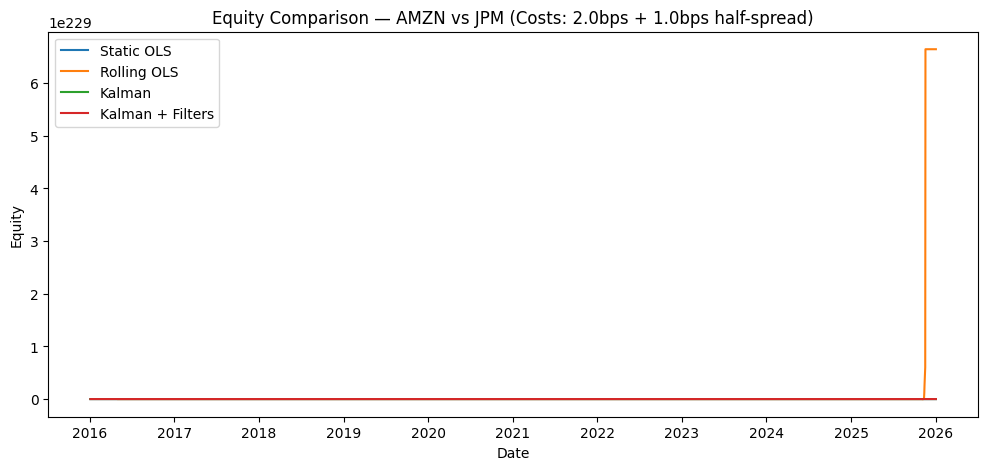

In [13]:
# Equity curve comparison
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(bt_static.index, bt_static["equity"], label="Static OLS")
ax.plot(bt_roll.index, bt_roll["equity"], label="Rolling OLS")
ax.plot(bt_kf.index, bt_kf["equity"], label="Kalman")
ax.plot(bt_kf_filtered.index, bt_kf_filtered["equity"], label="Kalman + Filters")
ax.set_title(f"Equity Comparison — {A} vs {B} (Costs: {COST_BPS}bps + {HALF_SPREAD_BPS}bps half-spread)")
ax.set_xlabel("Date")
ax.set_ylabel("Equity")
ax.legend()
plt.show()


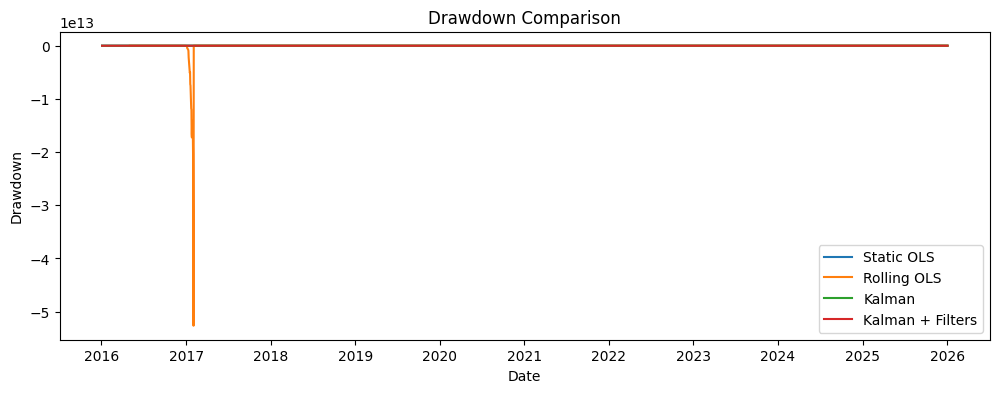

In [14]:
# Drawdowns
def drawdown(equity: pd.Series) -> pd.Series:
    peak = equity.cummax()
    return (equity / peak - 1.0).rename("drawdown")

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(drawdown(bt_static["equity"]), label="Static OLS")
ax.plot(drawdown(bt_roll["equity"]), label="Rolling OLS")
ax.plot(drawdown(bt_kf["equity"]), label="Kalman")
ax.plot(drawdown(bt_kf_filtered["equity"]), label="Kalman + Filters")
ax.set_title("Drawdown Comparison")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.legend()
plt.show()


## Portfolio constraints (optional multi-pair)

A **simple template** to trade multiple pairs simultaneously with:

- Equal-weight allocation **or**
- Inverse-vol weighting (rough risk parity) using recent spread volatility
- Gross exposure cap


In [15]:
from itertools import combinations

PAIRS = list(combinations(prices.columns.tolist(), 2))

def trade_pair_variant(prices: pd.DataFrame, pair: tuple[str,str], variant: str,
                       entry_z: float, exit_z: float, cost_bps: float, half_spread_bps: float) -> pd.DataFrame:
    a, b = pair
    pA, pB = prices[a], prices[b]

    if variant == "static_ols":
        beta = ols_beta(pA, pB)
        spr = spread(pA, pB, beta)
        z = rolling_zscore(spr, lookback=60)
        tok = None
    elif variant == "rolling_ols":
        beta = rolling_ols_beta(pA, pB, window=252)
        spr = spread(pA, pB, beta)
        z = rolling_zscore(spr, lookback=60)
        tok = None
    elif variant == "kalman":
        beta = kalman_beta(pA, pB, q=1e-5, r=1e-2)
        spr = spread(pA, pB, beta)
        z = rolling_zscore(spr, lookback=60)
        tok = None
    elif variant == "kalman_filters":
        beta = kalman_beta(pA, pB, q=1e-5, r=1e-2)
        spr = spread(pA, pB, beta)
        z = rolling_zscore(spr, lookback=60)
        tok = (vol_filter(spr, 20, 0.8) & trend_filter(spr, 60, 1.5)).rename("trade_ok")
    else:
        raise ValueError("Unknown variant")

    bt = backtest_with_beta(pA, pB, beta, z, trade_ok=tok,
                            entry_z=entry_z, exit_z=exit_z,
                            cost_bps=cost_bps, half_spread_bps=half_spread_bps)
    bt["pair"] = f"{a}-{b}"
    return bt

def combine_pairs_portfolio(
    backtests: list[pd.DataFrame],
    method: str = "equal",
    vol_lookback: int = 60,
    gross_cap: float = 1.0,
) -> pd.DataFrame:
    idx = backtests[0].index
    for bt in backtests[1:]:
        idx = idx.intersection(bt.index)

    nets, weights = [], []
    for bt in backtests:
        d = bt.loc[idx].copy()
        net = d["net_pnl"].rename(d["pair"].iloc[0])
        nets.append(net)

        if method == "equal":
            w = pd.Series(1.0, index=idx)
        else:
            vol = net.rolling(vol_lookback, min_periods=max(30, vol_lookback//2)).std(ddof=0)
            w = 1.0 / (vol + 1e-8)
        weights.append(w.rename(net.name))

    net_mat = pd.concat(nets, axis=1).fillna(0.0)
    w_mat = pd.concat(weights, axis=1).fillna(0.0)

    w_abs_sum = w_mat.abs().sum(axis=1).replace(0.0, np.nan)
    w_norm = (w_mat.div(w_abs_sum, axis=0) * gross_cap).fillna(0.0)

    port_net = (net_mat * w_norm).sum(axis=1).rename("net_pnl_port")
    equity = (1.0 + port_net).cumprod().rename("equity_port")

    out = pd.concat([port_net, equity], axis=1)
    out["gross_exposure"] = w_norm.abs().sum(axis=1)
    return out

pairs_to_trade = [("NVDA","JPM"), ("AMZN","META")]
bts = [trade_pair_variant(prices, p, "kalman_filters", ENTRY_Z, EXIT_Z, COST_BPS, HALF_SPREAD_BPS) for p in pairs_to_trade]
port = combine_pairs_portfolio(bts, method="inv_vol", vol_lookback=60, gross_cap=1.0)

perf_stats(port["equity_port"])


{'annualized_return': 0.3288319149832266,
 'annualized_vol': 0.1524197667561455,
 'sharpe': 1.9411644881705559,
 'max_drawdown': -0.1040395681232813,
 'win_rate_daily': 0.1026252983293556,
 'equity_start': 1.0,
 'equity_end': 17.05142732972824,
 'n_days': 2515}

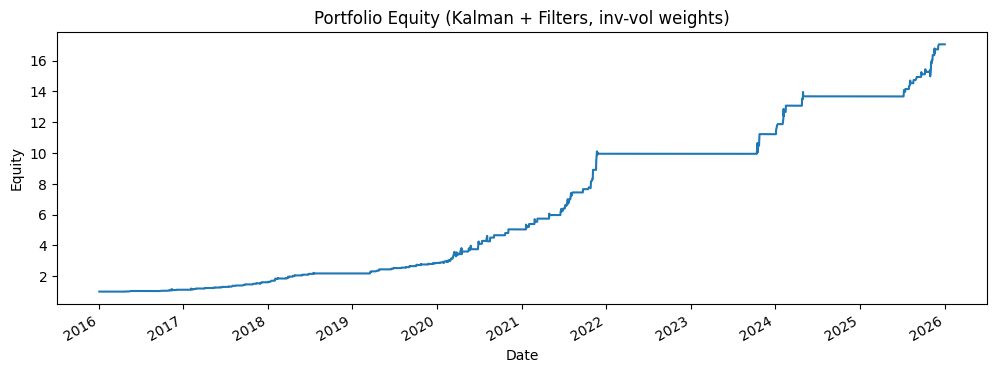

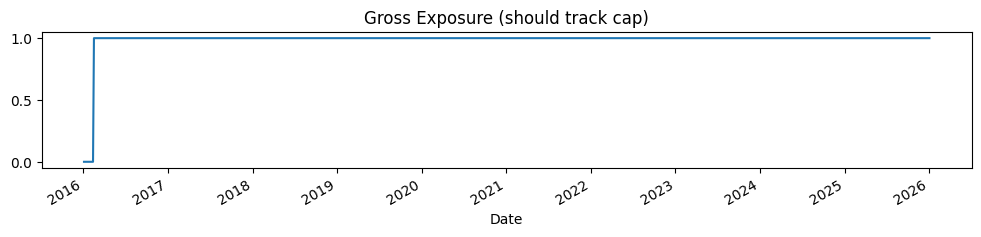

In [16]:
# Plot portfolio equity + exposure
ax = port["equity_port"].plot(figsize=(12, 4), title="Portfolio Equity (Kalman + Filters, inv-vol weights)")
ax.set_xlabel("Date")
ax.set_ylabel("Equity")
plt.show()

ax = port["gross_exposure"].plot(figsize=(12, 2), title="Gross Exposure (should track cap)")
ax.set_xlabel("Date")
plt.show()


## Save outputs

In [17]:
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

bt_kf_filtered.to_csv(OUT_DIR / f"pair_{A}_{B}_kalman_filters_backtest.csv", index=True)
stats.to_csv(OUT_DIR / f"pair_{A}_{B}_variant_stats.csv", index=True)
port.to_csv(OUT_DIR / "portfolio_kalman_filters.csv", index=True)

print("Saved outputs to:", OUT_DIR)


Saved outputs to: /Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/notebooks/outputs


## Notes / Next upgrades

- Use a **2D Kalman state** \([\alpha_t, \beta_t]\) to handle intercept drift  
- Calibrate \(q, r\) via likelihood or CV  
- Add hard risk controls: stop-loss, max hold time, drawdown circuit breaker  
- Wrap this inside the **walk-forward** framework (Notebook 03 scaffold)  
- Replace cost proxies with per-share commissions + spread-based slippage
